<a href="https://colab.research.google.com/github/Ashish265/Machine-Learning-projects/blob/master/Bike_Sharing_Demand_Prediction_Using_Regression_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


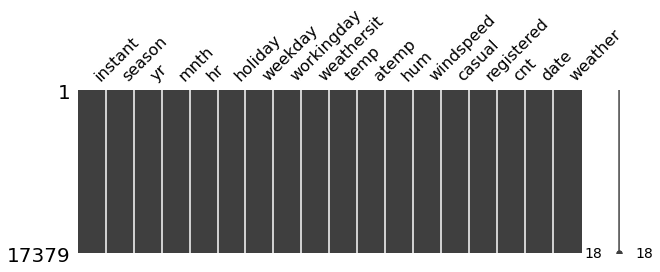

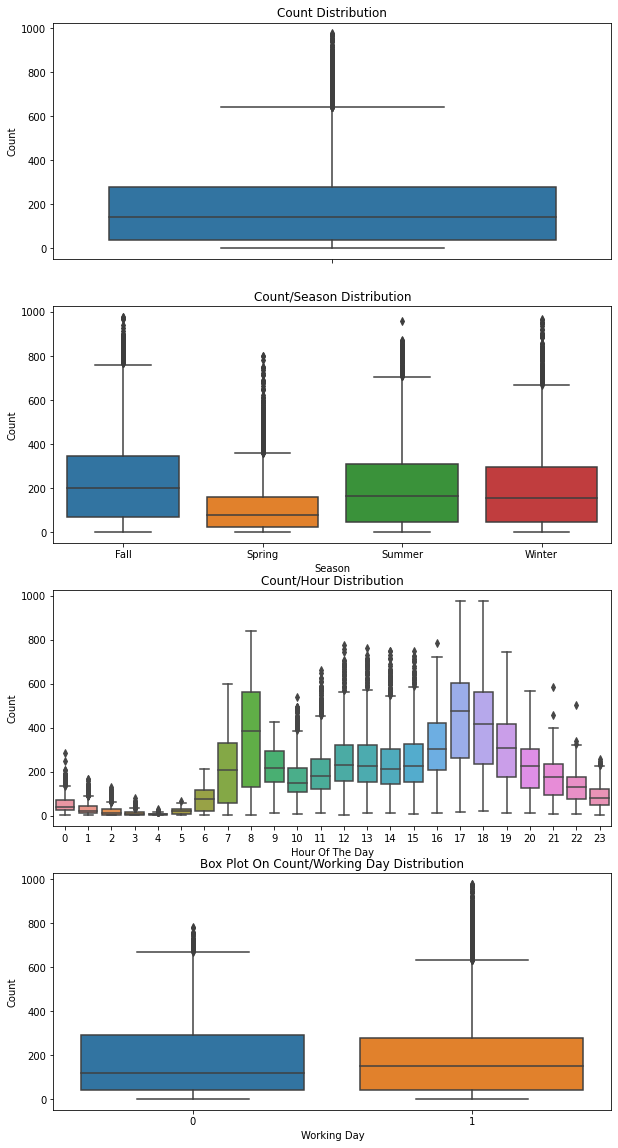

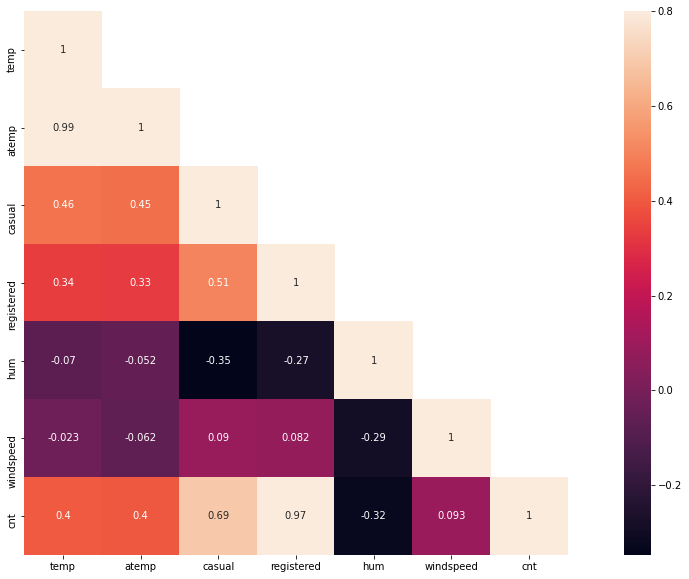

In [1]:
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Reading the data
data = pd.read_csv('/content/hour.csv', sep = ',')

# Separate the date
seasonMap = {1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" }
weatherMap = {1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
              2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
              3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
              4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " }

data["date"] = data.dteday.apply(lambda x : x.split()[0])
data["weekday"] = data.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
data["season"] = data.season.map(seasonMap)
data["weather"] = data.weathersit.map(weatherMap)

categoryVariableList  = ["hr","weekday","mnth","season","weather","holiday","workingday"]
for var in categoryVariableList:
    data[var] = data[var].astype("category")
    
data = data.drop(["dteday"],axis=1)

# Missing data detection
msno.matrix(data,figsize=(10,3))

# Outliners detection
fig, axes = plt.subplots(nrows=4,ncols=1)
fig.set_size_inches(10, 20)
sn.boxplot(data=data,y="cnt",orient="v",ax=axes[0])
sn.boxplot(data=data,y="cnt",x="season",orient="v",ax=axes[1])
sn.boxplot(data=data,y="cnt",x="hr",orient="v",ax=axes[2])
sn.boxplot(data=data,y="cnt",x="workingday",orient="v",ax=axes[3])

axes[0].set(ylabel='Count',title="Count Distribution")
axes[1].set(xlabel='Season', ylabel='Count',title="Count/Season Distribution")
axes[2].set(xlabel='Hour Of The Day', ylabel='Count',title="Count/Hour Distribution")
axes[3].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count/Working Day Distribution")

# Correlation analasys
corrMatt = data[["temp","atemp","casual","registered","hum","windspeed","cnt"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

RMSLE Value For Random Forest:  0.2868062610313444


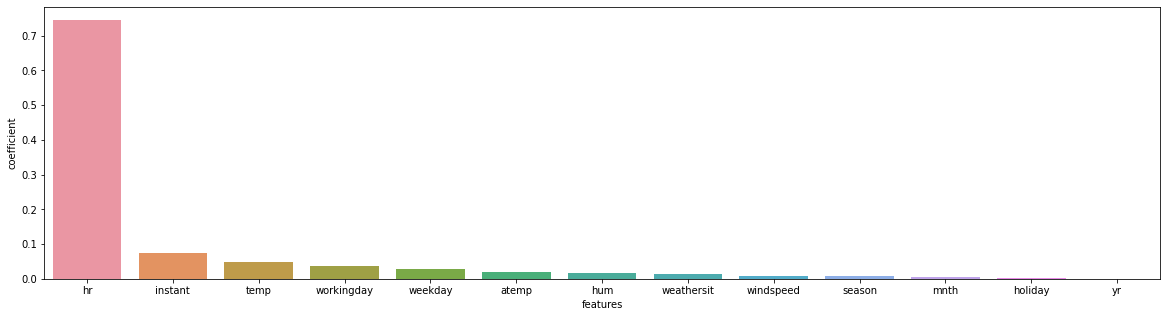

In [6]:
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sn
import matplotlib.pyplot as plt

# Loading data
data = pd.read_csv('hour.csv', sep = ',')

# Separate date
data["date"] = data.dteday.apply(lambda x : x.split()[0])
data["weekday"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())

# Categorical Features and drop features
categoricalFeatureNames = ["season","holiday","workingday","weathersit","weekday","mnth","yr","hr"]
numericalFeatureNames = ["temp","hum","windspeed","atemp"]
dropFeatures = ['casual',"cnt","dteday","date","registered"]

for var in categoricalFeatureNames:
    data[var] = data[var].astype("category")

# Build Train and test data
data = data[pd.notnull(data['cnt'])].sort_values(by=["dteday"])
y = data["cnt"]

data  = data.drop(dropFeatures,axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( data, y, test_size=0.3, random_state=42)

# Create model
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=500)
rfModel.fit(X = X_train,y = np.log1p(y_train))
preds = rfModel.predict(X= X_test)

# Analyze the results
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

print ("RMSLE Value For Random Forest: ",rmsle(np.exp(np.log1p(y_test)),np.exp(preds),False))

features = pd.DataFrame()
features['features'] = X_train.columns
features['coefficient'] = rfModel.feature_importances_
features.sort_values(by=['coefficient'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(20,5)
sn.barplot(data=features,x="features",y="coefficient",ax=ax)